# Dog or Wolf - ResNetファインチューニング

In [1]:
from glob import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from natsort import natsorted
from PIL import Image
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.functional import accuracy
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, resnet18

In [2]:
# GPUチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Transforms定義

In [3]:
# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])
# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## データセット定義

In [4]:
data_dir = '../data/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [5]:
# データ件数確認
print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

学習データ: 40件
検証データ: 10件


## データローダー定義

In [6]:
batch_size = 5
# 学習データ
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# 検証データ
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
for data in train_loader:
    print(data[0].shape)
    print(data[1])
    break

torch.Size([5, 3, 224, 224])
tensor([1, 0, 0, 1, 0])


## 学習

In [8]:
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.feature = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.fc = nn.Linear(1000, 2)

    def forward(self, x):
        h = self.feature(x)
        h = self.fc(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer


In [9]:
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp01')
trainer = pl.Trainer(max_epochs=100, accelerator='cpu', deterministic=False, logger=logger)
trainer.fit(net, train_loader, test_loader)

Seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/roki/work/kikagaku_apps/2024-04/dog-or-wolf/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | feature | ResNet | 11.7 M | train
1 | fc      | Linear | 2.0 K  | train
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.766    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/roki/work/kikagaku_apps/2024-04/dog-or-wolf/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/roki/work/kikagaku_apps/2024-04/dog-or-wolf/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/roki/work/kikagaku_apps/2024-04/dog-or-wolf/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s, v_num=1]


In [15]:
log = pd.read_csv('./logs/my_exp01/version_1/metrics.csv')

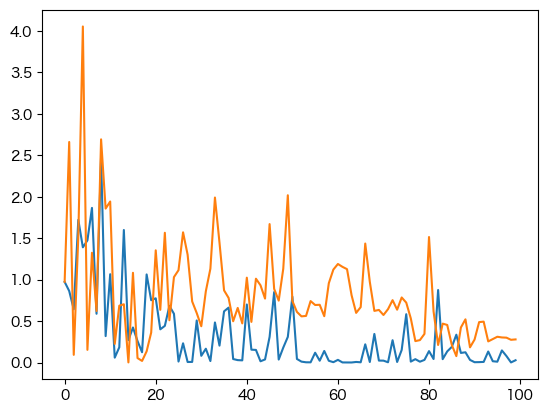

In [16]:
log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();

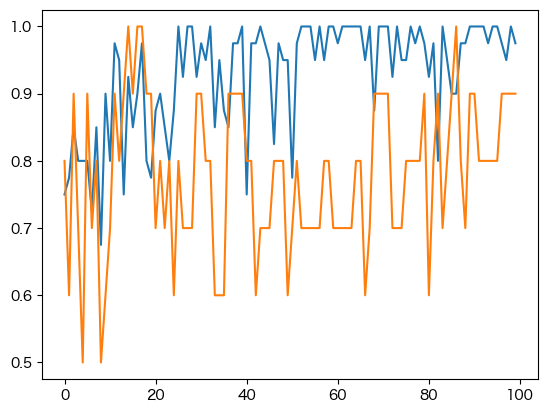

In [17]:
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();

## モデルの保存

In [13]:
# 学習後のモデル全体をファイルに保存
torch.save(net, './model_resnet18.pth')

In [18]:
# 学習後の重みをファイルに保存
torch.save(net.state_dict(), './model_resnet18_state.pth')